In [1]:
# Setup and Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from train import train
from model_test import *
from atk import ATTACK_CONFIGS
import torch.optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
from model import *
import os
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [3]:
# Training configurations
configs = [
    {'name': 'NonSpiking_WideResNet16_Clean', 'use_spike': False, 'atk': 'none', 'lr': 0.01, 'batch_size': 64, 'epochs': 50},
    {'name': 'NonSpiking_WideResNet16-GN', 'use_spike': False, 'atk': 'gn', 'lr': 0.01, 'batch_size': 64, 'epochs': 50},
    {'name': 'NonSpiking_WideResNet16-PGD', 'use_spike': False, 'atk': 'pgd', 'lr': 0.01, 'batch_size': 64, 'epochs': 50},
    {'name': 'Spiking_WideResNet16-Clean', 'use_spike': True, 'atk': 'none', 'model_size': 18, 'lr': 0.01, 'batch_size': 64, 'epochs': 50, 'T': 4},
    {'name': 'Spiking_WideResNet16-GN', 'use_spike': True, 'atk': 'gn', 'model_size': 18, 'lr': 0.01, 'batch_size': 64, 'epochs': 50, 'T': 4},
    {'name': 'Spiking_WideResNet16-PGD', 'use_spike': True, 'atk': 'pgd', 'model_size': 18, 'lr': 0.01, 'batch_size': 64, 'epochs': 50, 'T': 4}
]

In [4]:
# Training Phase

In [5]:
# Train models with updated parameters and different raw image proportions
training_results = {}

# Raw image proportions to test
raw_proportions = [0.0, 0.25, 0.5, 0.75]

for config in configs:
    config_results = {}
    
    for raw_prop in raw_proportions:
        print(f"\nTraining {config['name']} with raw image proportion {raw_prop}...")
        
        # Extract training parameters with defaults
        model_type = config.get('model_type', 'standard')
        use_spike = config.get('use_spike', False)
        print(f"use_spike: {use_spike}")
        atk = config.get('atk', 'none')
        epochs = 10 # config.get('epochs', 10)
        batch_size = config.get('batch_size', 64)
        lr = 0.001 # config.get('lr', 0.1)
        T = config.get('T', 4)
        optimizer = 'adamw'
        
        # Train model with optimized parameters and specific raw image proportion
        result = train(
            #model_type=model_type,
            use_spike=use_spike,
            atk=atk,
            epochs=epochs,
            batch_size=batch_size,
            lr=lr,
            T=T,
            optimizer_type=optimizer,
            raw_prop=raw_prop
        )
        
        # Store results for this proportion
        config_name = f"{config['name']}_raw_prop_{raw_prop:.2f}"
        config_results[raw_prop] = result
        print(f"Training completed for {config_name}")
        print(f"Final test accuracy: {result['best_acc']:.2f}%")
        print(f"Model saved to: ./weight/{model_type}_spike_{use_spike}_atk_{atk}_{optimizer}_raw_prop_{raw_prop:.2f}.pth")
    
    # Store all proportion results for this config
    training_results[config['name']] = config_results

# Print summary of results
print("\n\n========== Summary of Results ==========")
for config_name, prop_results in training_results.items():
    print(f"\nResults for {config_name}:")
    for prop, result in prop_results.items():
        print(f"  Raw Proportion {prop:.2f}: Test Accuracy {result['best_acc']:.2f}%")


Training NonSpiking_WideResNet16_Clean with raw image proportion 0.0...
use_spike: False
Training on 6000 samples, testing on 1000 samples
Attack type: none, Optimizer: adamw, Raw image proportion: 0.0
Using standard WideResNet16
Epoch [1/10], Train Loss: 0.5374, Train Acc: 85.70%, Test Acc: 85.20%
New best model saved with accuracy: 85.20%
Epoch [2/10], Train Loss: 0.1093, Train Acc: 96.77%, Test Acc: 91.10%
New best model saved with accuracy: 91.10%
Epoch [3/10], Train Loss: 0.0891, Train Acc: 97.47%, Test Acc: 96.80%
New best model saved with accuracy: 96.80%
Epoch [4/10], Train Loss: 0.0578, Train Acc: 98.32%, Test Acc: 97.80%
New best model saved with accuracy: 97.80%
Epoch [5/10], Train Loss: 0.0353, Train Acc: 99.00%, Test Acc: 97.60%
Epoch [6/10], Train Loss: 0.0396, Train Acc: 98.75%, Test Acc: 95.60%
Epoch [7/10], Train Loss: 0.0290, Train Acc: 99.13%, Test Acc: 98.50%
New best model saved with accuracy: 98.50%
Epoch [8/10], Train Loss: 0.0203, Train Acc: 99.35%, Test Acc: 9

In [6]:
# Training Results Visualization

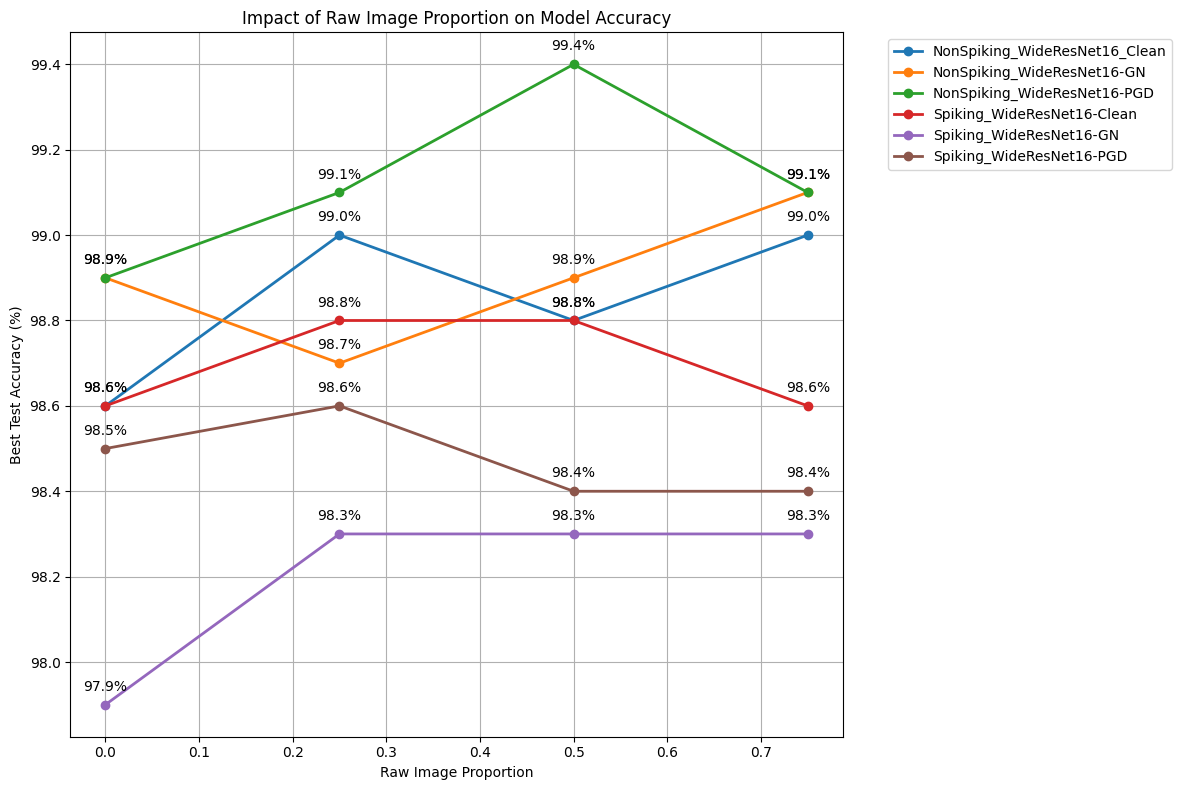

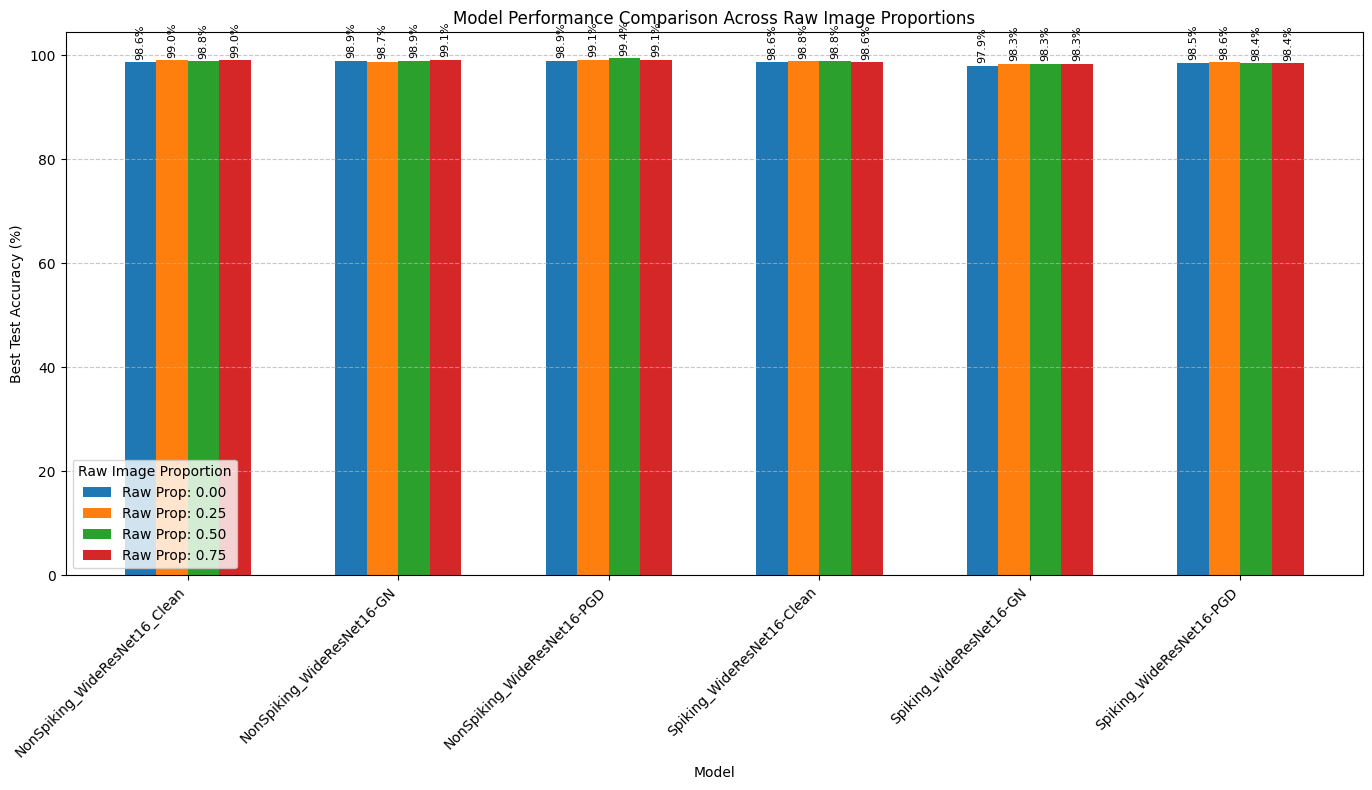

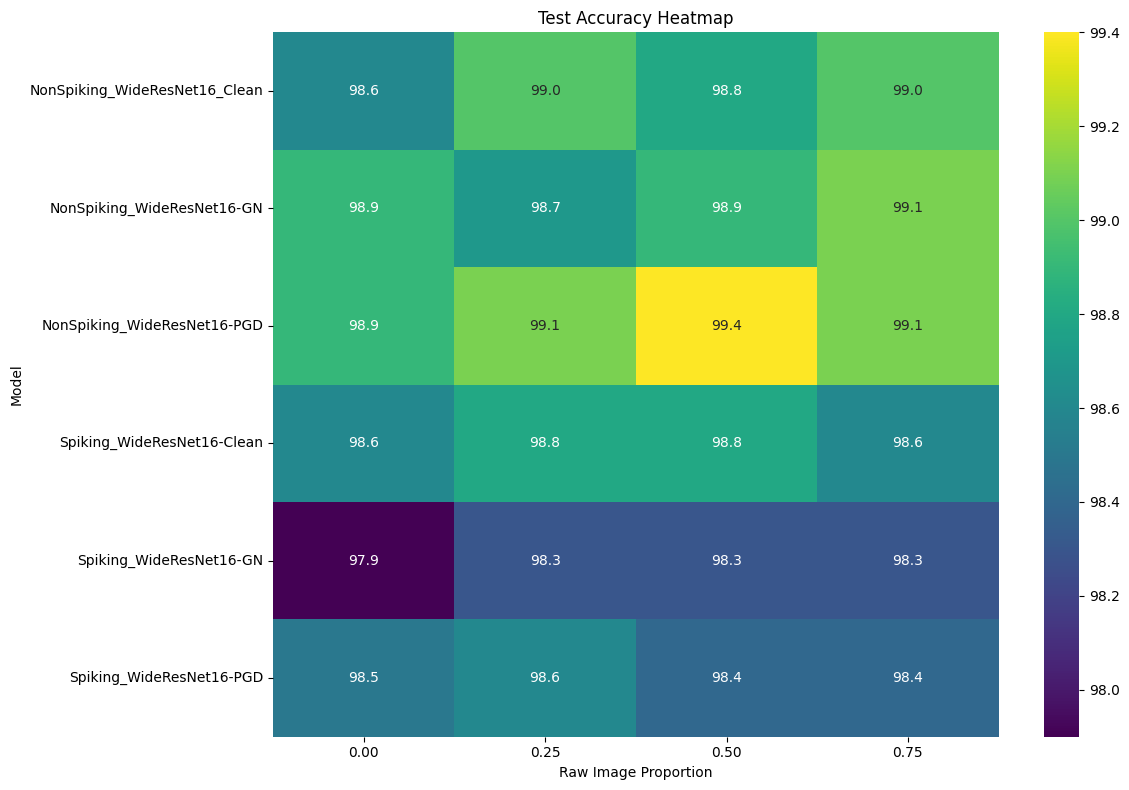

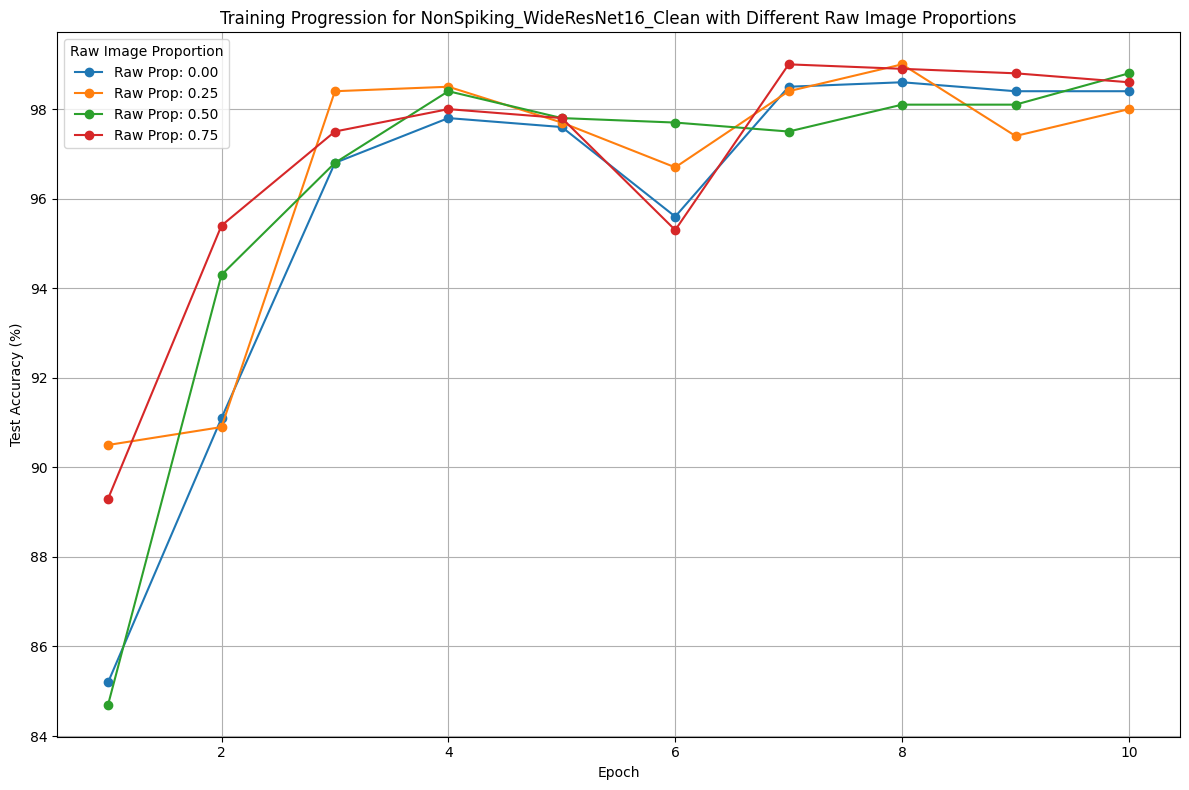


========== RESULTS SUMMARY ==========
Model                          Raw Prop   Best Acc   Final Acc  Final Loss
----------------------------------------------------------------------
NonSpiking_WideResNet16_Clean  0.00       98.60      98.40      0.0251    
NonSpiking_WideResNet16_Clean  0.25       99.00      98.00      0.0178    
NonSpiking_WideResNet16_Clean  0.50       98.80      98.80      0.0135    
NonSpiking_WideResNet16_Clean  0.75       99.00      98.60      0.0195    
----------------------------------------------------------------------
NonSpiking_WideResNet16-GN     0.00       98.90      98.90      0.0224    
NonSpiking_WideResNet16-GN     0.25       98.70      98.40      0.0179    
NonSpiking_WideResNet16-GN     0.50       98.90      96.80      0.0231    
NonSpiking_WideResNet16-GN     0.75       99.10      98.10      0.0223    
----------------------------------------------------------------------
NonSpiking_WideResNet16-PGD    0.00       98.90      98.90      0.0192   

In [7]:
def plot_training_progress_with_proportions(training_results):
    """
    Creates plots to visualize the impact of raw image proportions on model performance
    """
    # 1. Plot test accuracy vs raw image proportion for each model
    plt.figure(figsize=(12, 8))
    
    for model_name, prop_results in training_results.items():
        # Extract proportions and corresponding best accuracies
        proportions = sorted(prop_results.keys())
        accuracies = [prop_results[prop]['best_acc'] for prop in proportions]
        
        # Plot line for this model
        plt.plot(proportions, accuracies, marker='o', linestyle='-', linewidth=2, label=model_name)
    
    plt.xlabel('Raw Image Proportion')
    plt.ylabel('Best Test Accuracy (%)')
    plt.title('Impact of Raw Image Proportion on Model Accuracy')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    # Add text annotations for each point
    for model_name, prop_results in training_results.items():
        proportions = sorted(prop_results.keys())
        accuracies = [prop_results[prop]['best_acc'] for prop in proportions]
        
        for i, (prop, acc) in enumerate(zip(proportions, accuracies)):
            plt.annotate(f'{acc:.1f}%', 
                         (prop, acc),
                         textcoords="offset points", 
                         xytext=(0,10), 
                         ha='center')
    
    # Save the figure if results directory exists
    os.makedirs('./results', exist_ok=True)
    plt.savefig('./results/accuracy_vs_proportion.png', bbox_inches='tight')
    plt.show()
    
    # 2. Create bar chart comparing all models and proportions side by side
    plt.figure(figsize=(14, 8))
    
    # Set up the bar positions
    models = list(training_results.keys())
    proportions = sorted(list(training_results[models[0]].keys()))
    num_models = len(models)
    num_props = len(proportions)
    
    # Calculate positions
    bar_width = 0.15
    index = np.arange(num_models)
    
    # Plot bars for each proportion
    for i, prop in enumerate(proportions):
        accuracies = [training_results[model][prop]['best_acc'] for model in models]
        offset = (i - num_props/2 + 0.5) * bar_width
        bars = plt.bar(index + offset, accuracies, bar_width, 
                       label=f'Raw Prop: {prop:.2f}')
        
        # Add accuracy values on bars
        for j, bar in enumerate(bars):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{height:.1f}%',
                    ha='center', va='bottom', fontsize=8, rotation=90)
    
    plt.xlabel('Model')
    plt.ylabel('Best Test Accuracy (%)')
    plt.title('Model Performance Comparison Across Raw Image Proportions')
    plt.xticks(index, models, rotation=45, ha='right')
    plt.legend(title='Raw Image Proportion')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('./results/model_comparison_by_proportion.png', bbox_inches='tight')
    plt.show()
    
    # 3. Heatmap of performance
    plt.figure(figsize=(12, 8))
    
    # Create data for heatmap
    heatmap_data = np.zeros((len(models), len(proportions)))
    for i, model in enumerate(models):
        for j, prop in enumerate(proportions):
            heatmap_data[i, j] = training_results[model][prop]['best_acc']
    
    # Plot heatmap
    sns.heatmap(heatmap_data, annot=True, fmt='.1f', 
                xticklabels=[f'{p:.2f}' for p in proportions],
                yticklabels=models,
                cmap='viridis')
    plt.xlabel('Raw Image Proportion')
    plt.ylabel('Model')
    plt.title('Test Accuracy Heatmap')
    plt.tight_layout()
    plt.savefig('./results/accuracy_heatmap.png', bbox_inches='tight')
    plt.show()
    
    # 4. Plot training curves for the different proportions of one model
    # Pick the first model as an example
    model_to_plot = models[0]
    plt.figure(figsize=(12, 8))
    
    for prop, result in training_results[model_to_plot].items():
        epochs = range(1, len(result['test_accuracies']) + 1)
        plt.plot(epochs, result['test_accuracies'], marker='o', 
                 label=f'Raw Prop: {prop:.2f}')
    
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy (%)')
    plt.title(f'Training Progression for {model_to_plot} with Different Raw Image Proportions')
    plt.grid(True)
    plt.legend(title='Raw Image Proportion')
    plt.tight_layout()
    plt.savefig(f'./results/{model_to_plot}_training_curves.png', bbox_inches='tight')
    plt.show()
    
    # 5. Print summary table
    print("\n========== RESULTS SUMMARY ==========")
    print(f"{'Model':<30} {'Raw Prop':<10} {'Best Acc':<10} {'Final Acc':<10} {'Final Loss':<10}")
    print("-" * 70)
    
    for model in models:
        for prop in proportions:
            result = training_results[model][prop]
            best_acc = result['best_acc']
            final_acc = result['test_accuracies'][-1]
            final_loss = result['train_losses'][-1]
            print(f"{model:<30} {prop:<10.2f} {best_acc:<10.2f} {final_acc:<10.2f} {final_loss:<10.4f}")
        print("-" * 70)  # Separator between models

# Call the plotting function after training
plot_training_progress_with_proportions(training_results)

In [8]:
for config_name, result in training_results.items():
    print(config_name, result)

NonSpiking_WideResNet16_Clean {0.0: {'best_acc': 98.6, 'train_losses': [0.5373860764059615, 0.1093167170406656, 0.08911746397535218, 0.057800485678215295, 0.03530298981894838, 0.03958356914486974, 0.029043670604996224, 0.020251108500660656, 0.02488769567138119, 0.02507315065830629], 'train_accuracies': [85.7, 96.76666666666667, 97.46666666666667, 98.31666666666666, 99.0, 98.75, 99.13333333333334, 99.35, 99.21666666666667, 99.13333333333334], 'test_accuracies': [85.2, 91.1, 96.8, 97.8, 97.6, 95.6, 98.5, 98.6, 98.4, 98.4], 'raw_prop': 0.0}, 0.25: {'best_acc': 99.0, 'train_losses': [0.8044018136694077, 0.14103516868929913, 0.09083677051549262, 0.059081988666761426, 0.05593165153379929, 0.04127753427143189, 0.031522669502474523, 0.028717755389578166, 0.02690438488919407, 0.01782145669022476], 'train_accuracies': [76.98333333333333, 96.43333333333334, 97.3, 98.28333333333333, 98.3, 98.88333333333334, 99.06666666666666, 99.01666666666667, 99.06666666666666, 99.43333333333334], 'test_accuraci

In [9]:
# Test models with different attacks
test_results = {}

# List of attack types to test
attack_types = ['none', 'gn', 'pgd']

# List of model configurations to test
model_configs = [
    {"name": "NonSpiking_WideResNet16_Clean", "use_spike": False, "train_attack": "none"},
    {"name": "NonSpiking_WideResNet16-GN", "use_spike": False, "train_attack": "gn"},
    {"name": "NonSpiking_WideResNet16-PGD", "use_spike": False, "train_attack": "pgd"},
    {"name": "Spiking_WideResNet16-Clean", "use_spike": True, "train_attack": "none"},
    {"name": "Spiking_WideResNet16-GN", "use_spike": True, "train_attack": "gn"},
    {"name": "Spiking_WideResNet16-PGD", "use_spike": True, "train_attack": "pgd"}
]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Increase batch size for testing
test_batch_size = 256

for config in model_configs:
    config_name = config["name"]
    use_spike = config["use_spike"]
    train_attack = config["train_attack"]
    optimizer = 'adamw'  # Default optimizer
    
    model_path = f"./weight/standard_spike_{use_spike}_atk_{train_attack}_{optimizer}.pth"
    print(f"\nTesting {model_path}...")
    
    # Load model once for all attacks
    model = get_model(use_spike=use_spike)
    
    try:
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        model.eval()
        
        # Dictionary to store accuracies for this model
        model_results = {}
        
        # Test with different attacks
        for attack in attack_types:
            print(f"  Testing with {attack} attack...")
            acc, class_accs, conf_matrix = test(
                model=model,
                attack_type=attack,
                batch_size=test_batch_size,
                device=device,
                optimizer=optimizer
            )
            
            model_results[attack] = {
                'accuracy': acc,
                'class_accuracies': class_accs,
                'confusion_matrix': conf_matrix
            }
            
            print(f"    Accuracy: {acc:.2f}%")
        
        test_results[config_name] = model_results
    except Exception as e:
        print(f"Error testing {config_name}: {e}")
        test_results[config_name] = {'error': str(e)}


Testing ./weight/standard_spike_False_atk_none_adamw.pth...
Using standard WideResNet16
  Testing with none attack...
In test function, attack_type: none, optimizer: adamw
Model is non-spiking
Model has 2748614 parameters

DEBUG INFORMATION:
Sample predictions:

Sample outputs for none:
  Sample 0: Label=5, Predicted=5
  Logits: [-5.23741   -6.6166005 -6.5267043 -0.9789753 -5.606622  10.506854
 -4.336094  -6.5390606 -1.916178  -1.8112926]
  Sample 1: Label=3, Predicted=3
  Logits: [-4.866591   -5.818457   -3.629456    7.2364273  -3.725484    1.5297163
 -6.1882725  -4.586104   -1.5180264   0.20019017]
  Sample 2: Label=7, Predicted=7
  Logits: [-3.2149768  -3.116949    0.2413196  -1.5762368  -3.4226744  -4.4700084
 -5.802057    6.585427   -3.928787   -0.42183298]
  Sample 3: Label=4, Predicted=4
  Logits: [-3.8640263 -5.3211594 -4.115743  -5.4421115  7.075147  -3.682255
 -4.9336615 -4.5237246 -3.2066057  2.7505894]
  Sample 4: Label=1, Predicted=1
  Logits: [-4.4573708 10.197101  -4.47

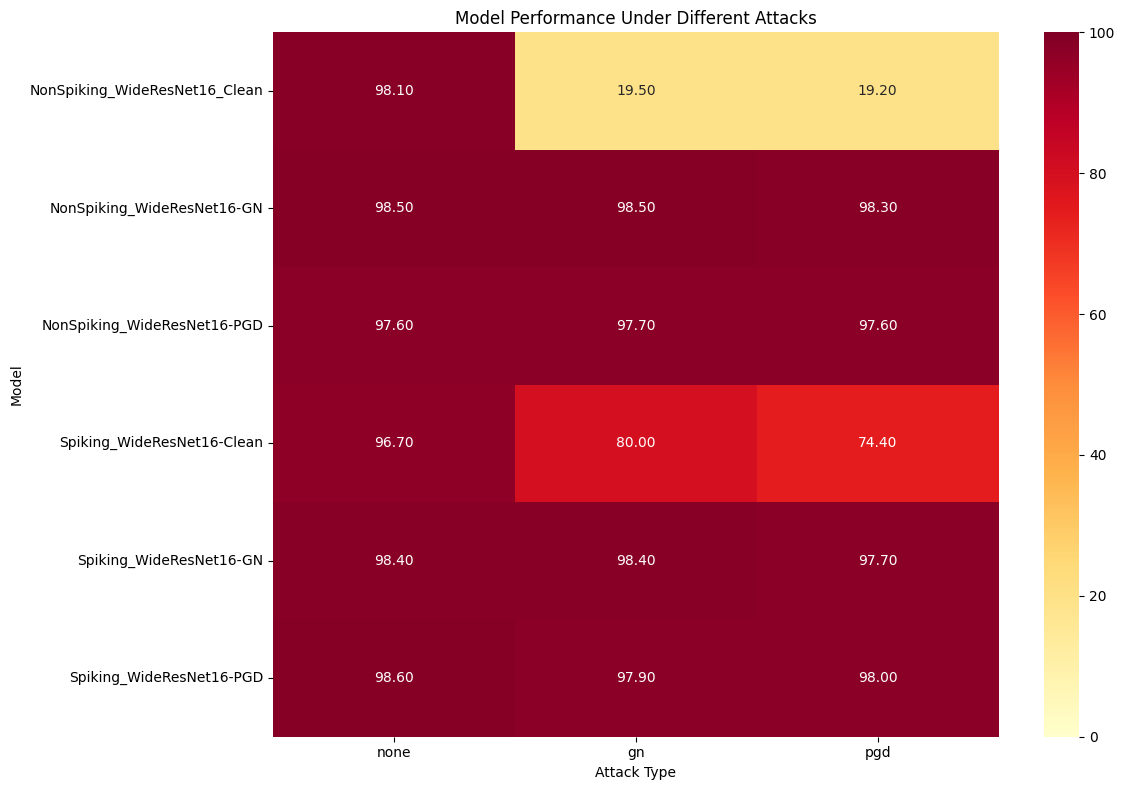

In [10]:
# Get model names and attack types
model_names = list(test_results.keys())
attack_names = ['none', 'gn', 'pgd']  # Make sure these match your attack types

if not model_names:
    print("No models were successfully tested. Please check the debug output above.")
else:
    # Initialize the comparison matrix with NaN values
    comparison_matrix = np.full((len(model_names), len(attack_names)), np.nan)
    
    # Fill the matrix with accuracies
    for i, model_name in enumerate(model_names):
        for j, attack_name in enumerate(attack_names):
            if attack_name in test_results[model_name]:
                comparison_matrix[i, j] = test_results[model_name][attack_name]['accuracy']
    
    # Check if we have any valid values
    if np.isnan(comparison_matrix).all():
        print("No valid accuracy values found in the results.")
    else:
        # Create heatmap
        plt.figure(figsize=(12, 8))
        sns.heatmap(comparison_matrix, 
                    annot=True, 
                    fmt='.2f',
                    xticklabels=attack_names,
                    yticklabels=model_names,
                    cmap='YlOrRd',
                    vmin=0,  # Set minimum value to 0
                    vmax=100)  # Set maximum value to 100 for accuracy percentage

        plt.title('Model Performance Under Different Attacks')
        plt.xlabel('Attack Type')
        plt.ylabel('Model')
        plt.tight_layout()
        plt.show()

In [11]:
# Per-Class Analysis
test_results

{'NonSpiking_WideResNet16_Clean': {'none': {'accuracy': 98.1,
   'class_accuracies': [99.01960784313725,
    98.23008849557522,
    99.01960784313725,
    100.0,
    100.0,
    97.59036144578313,
    97.77777777777777,
    97.3913043478261,
    95.78947368421052,
    96.15384615384616],
   'confusion_matrix': array([[101.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
          [  0., 111.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.],
          [  0.,   0., 101.,   1.,   0.,   0.,   0.,   0.,   0.,   0.],
          [  0.,   0.,   0.,  93.,   0.,   0.,   0.,   0.,   0.,   0.],
          [  0.,   0.,   0.,   0., 103.,   0.,   0.,   0.,   0.,   0.],
          [  0.,   0.,   0.,   2.,   0.,  81.,   0.,   0.,   0.,   0.],
          [  0.,   0.,   0.,   0.,   0.,   2.,  88.,   0.,   0.,   0.],
          [  0.,   1.,   0.,   1.,   1.,   0.,   0., 112.,   0.,   0.],
          [  0.,   0.,   0.,   3.,   0.,   1.,   0.,   0.,  91.,   0.],
          [  0.,   0.,   0.,   0.,   4.,   0

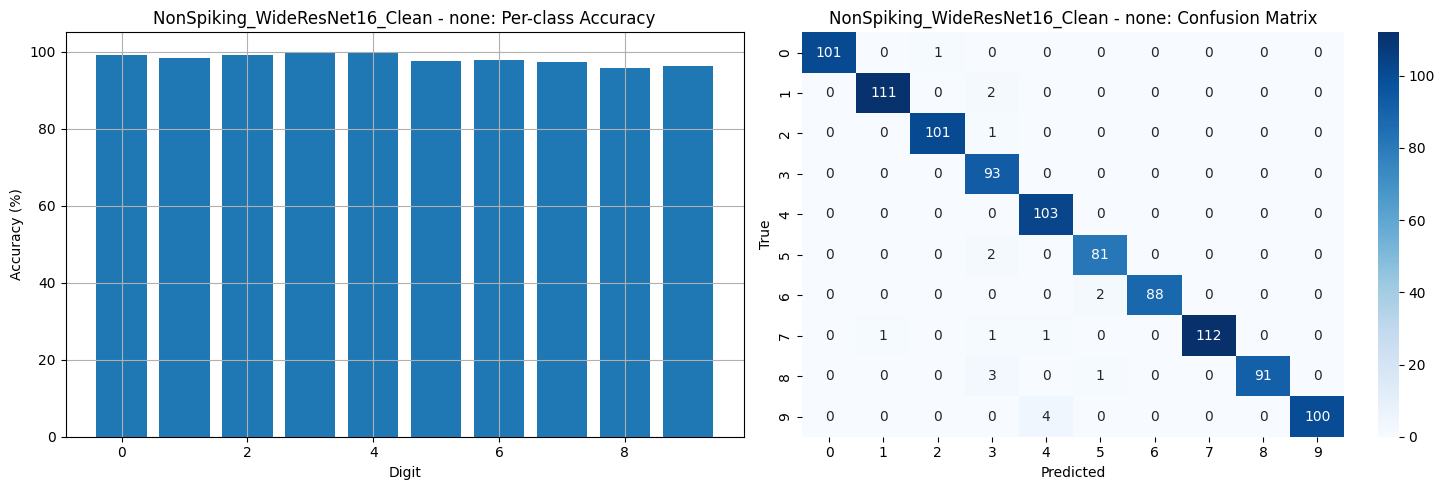

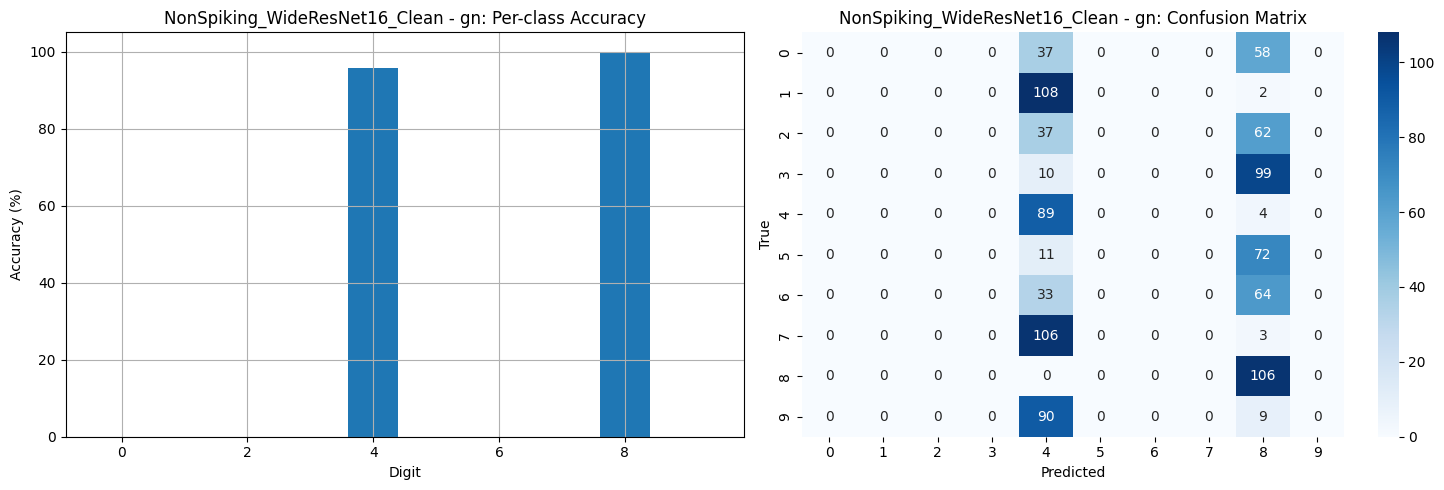

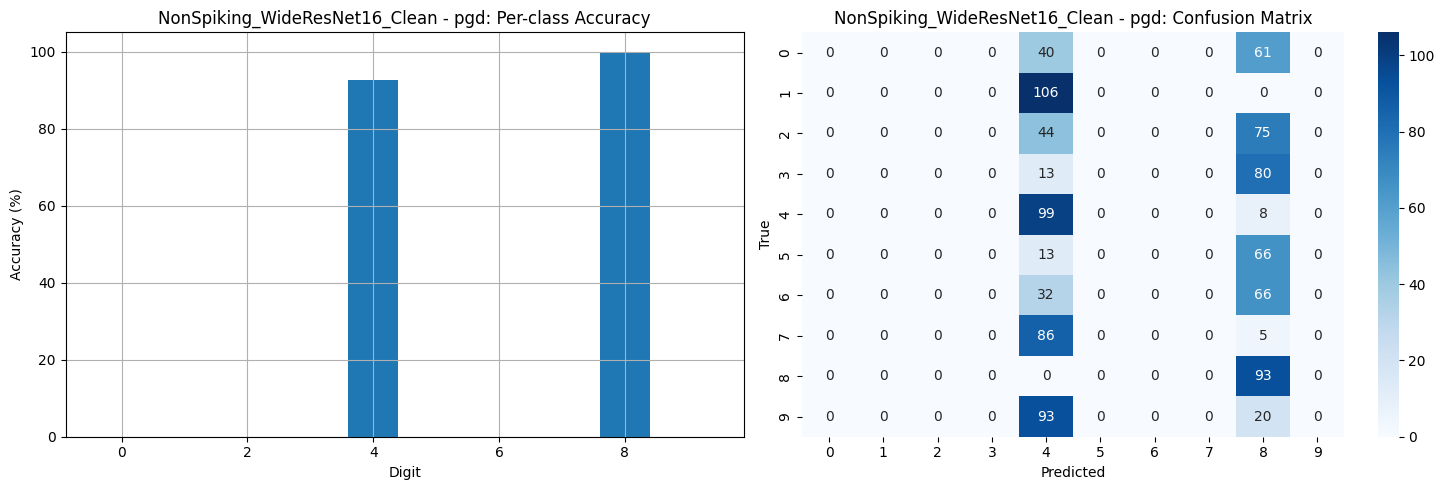

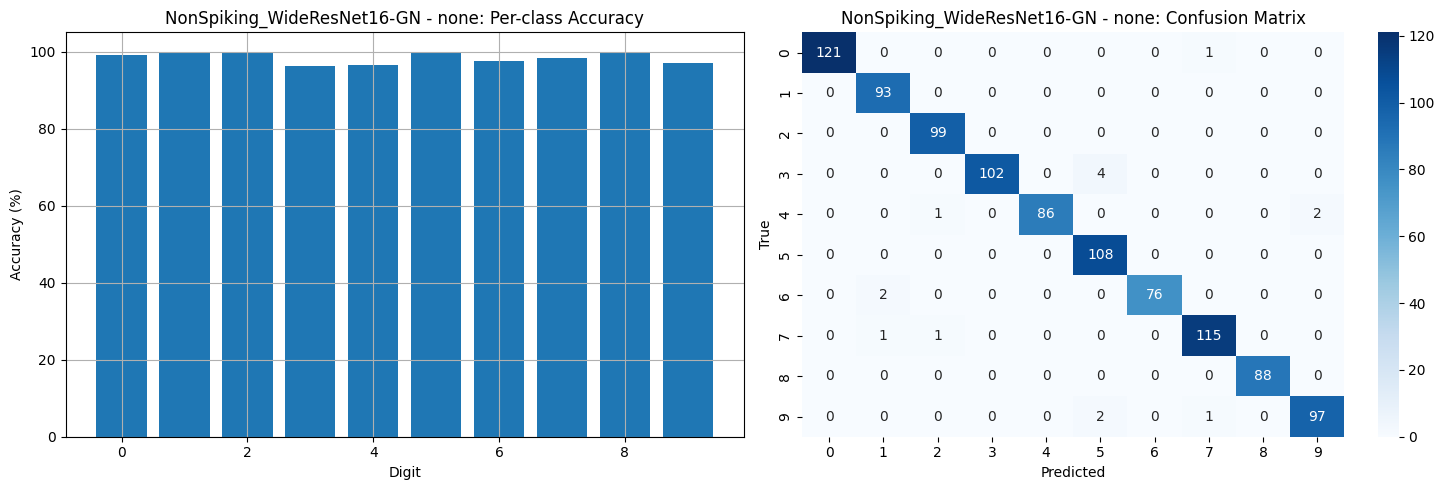

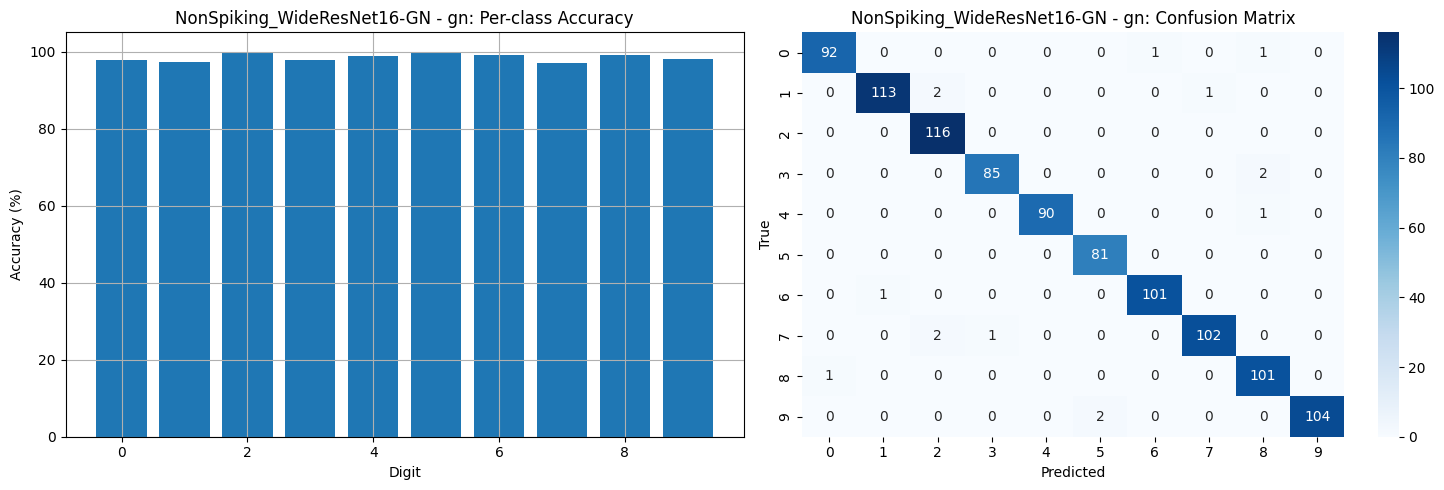

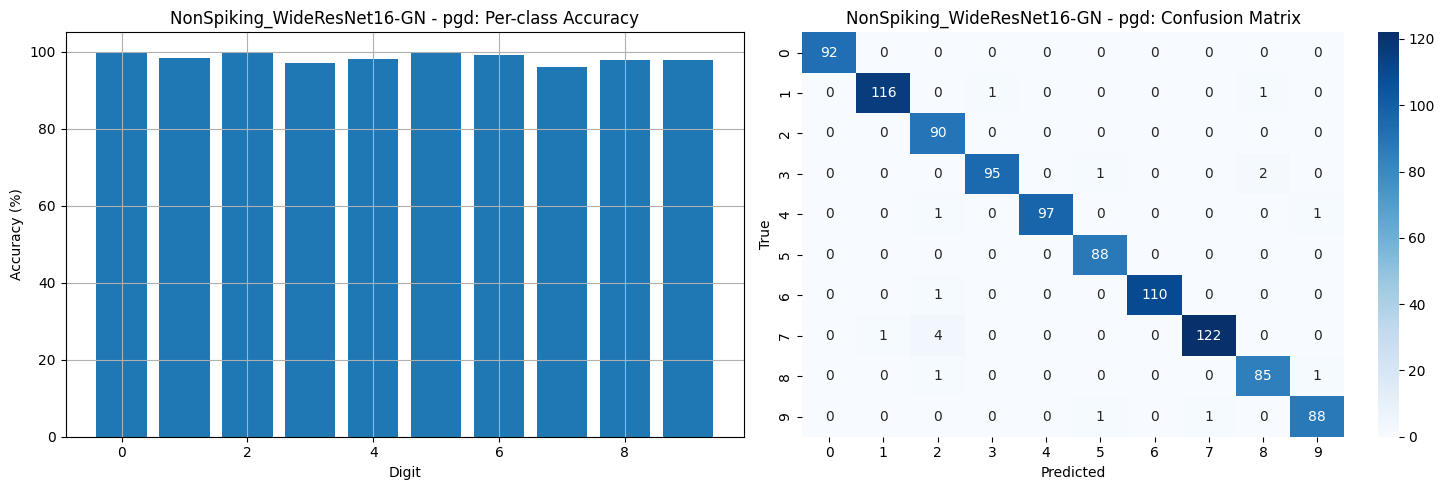

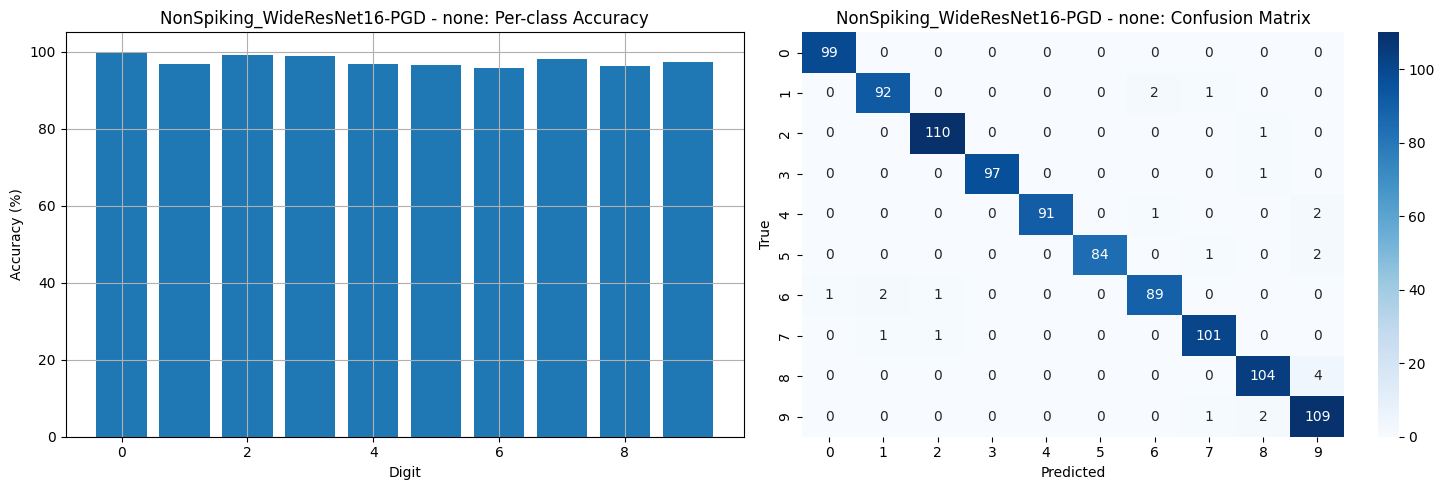

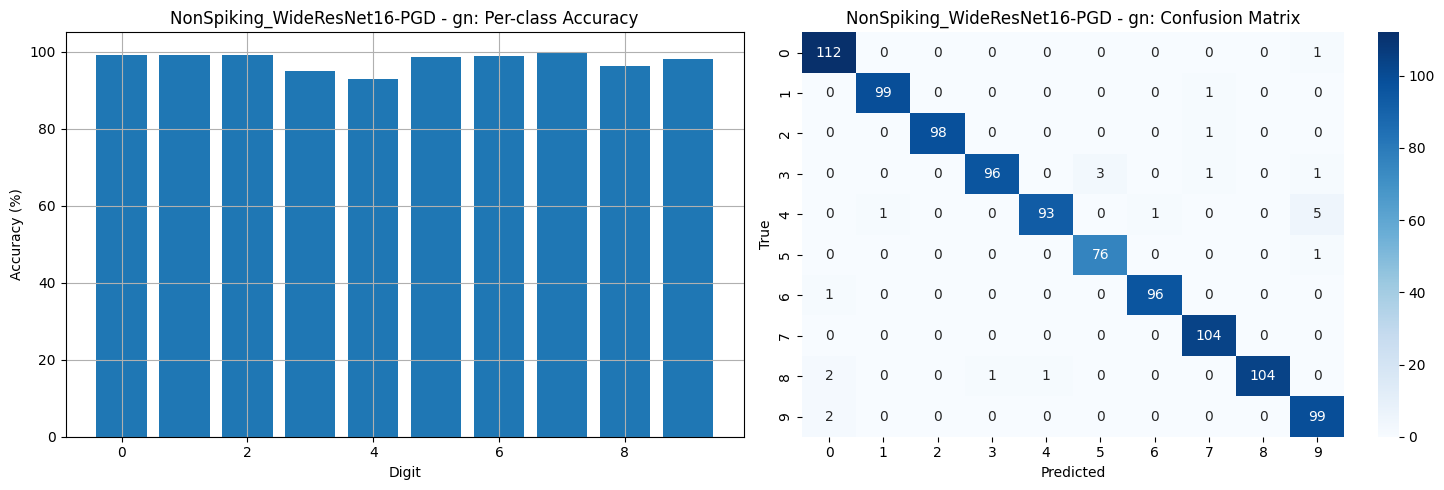

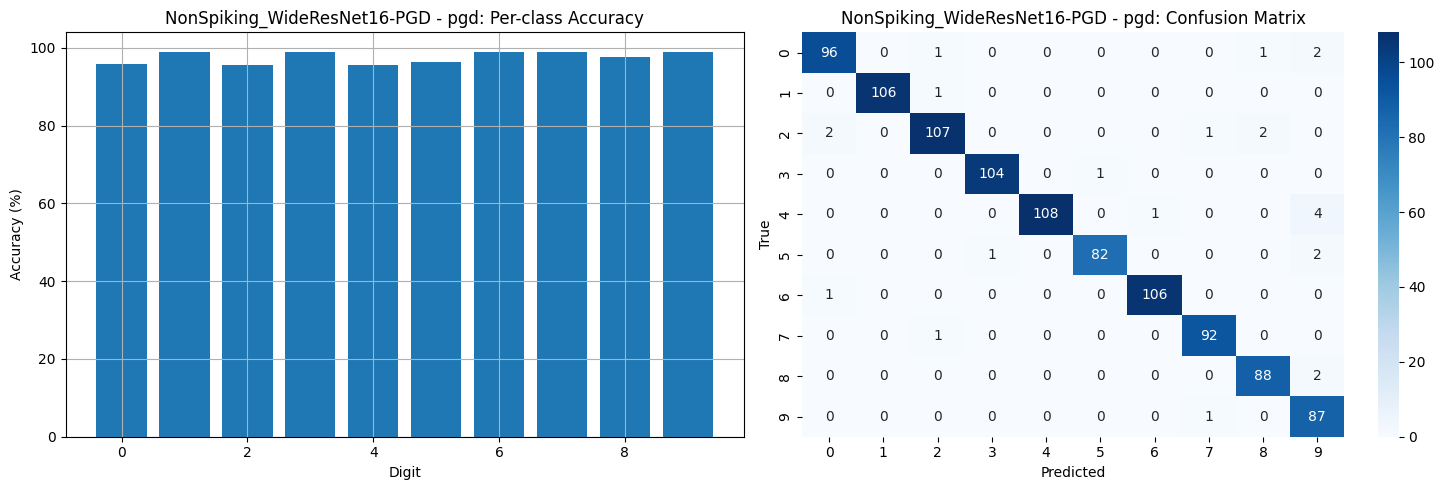

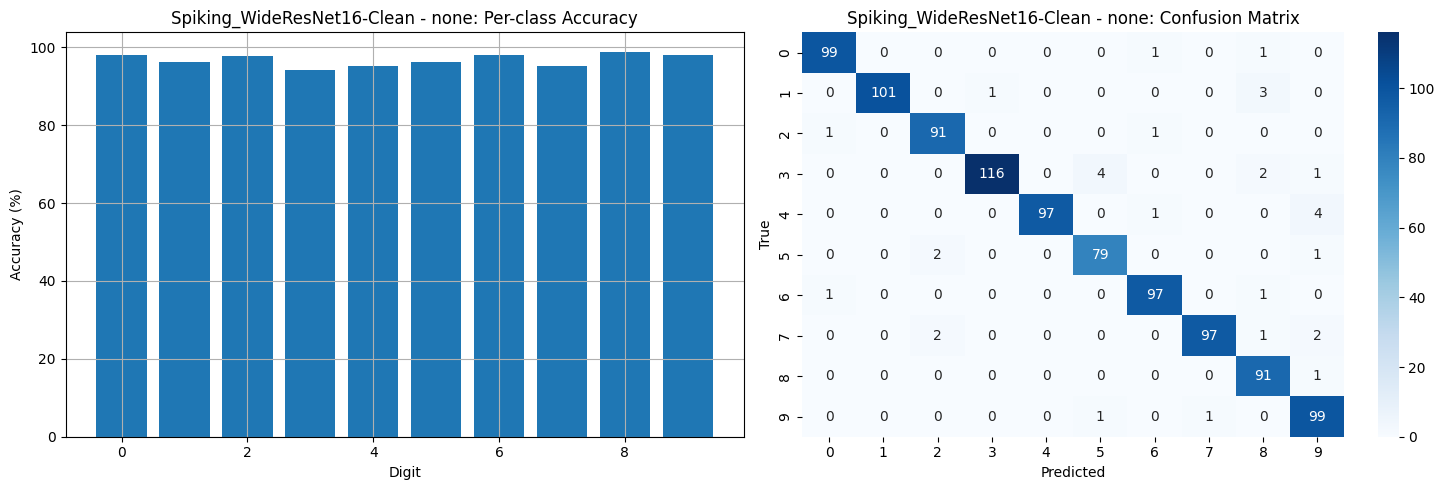

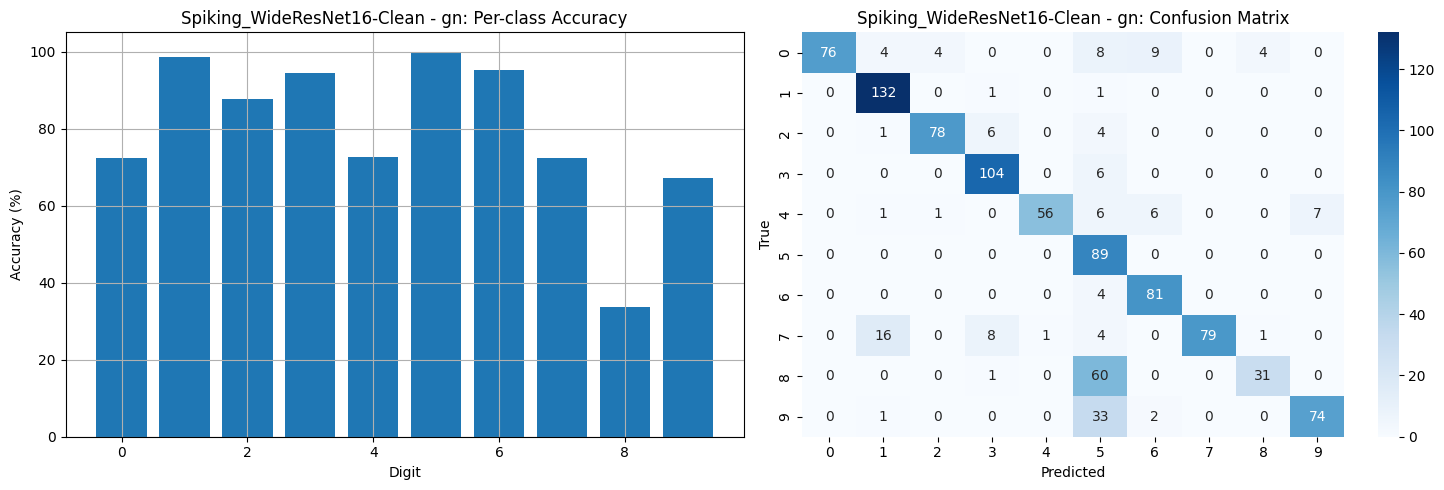

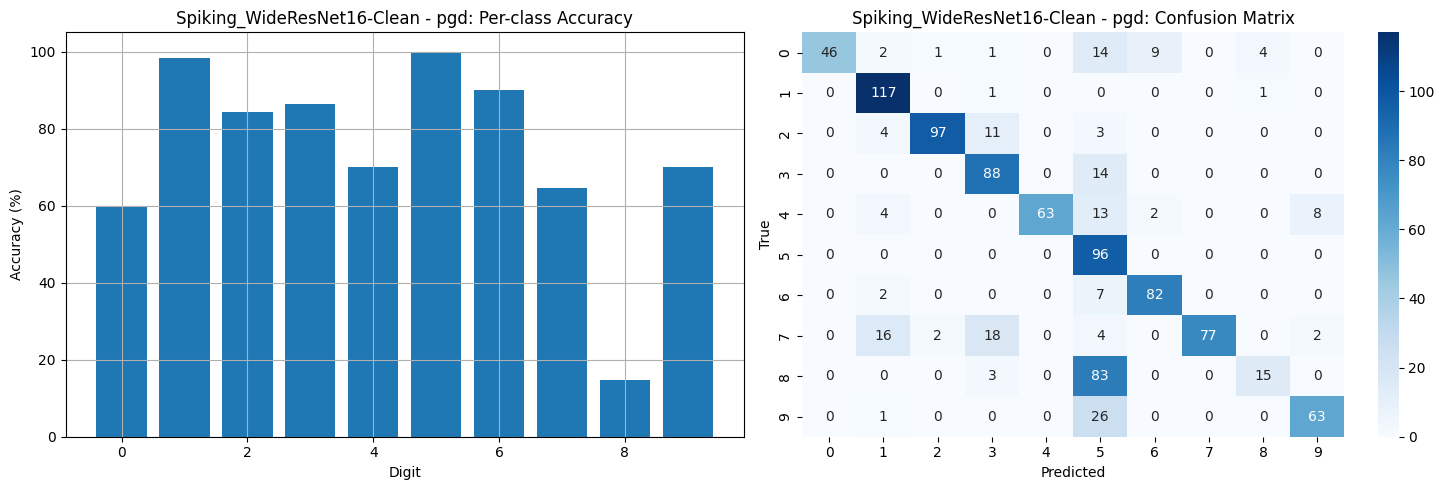

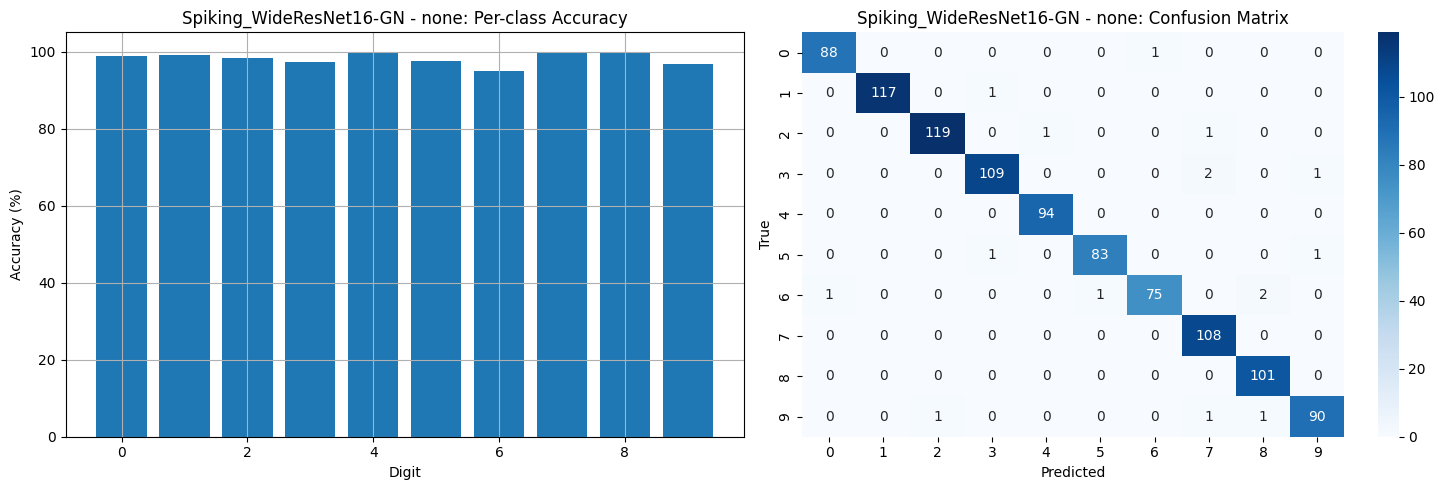

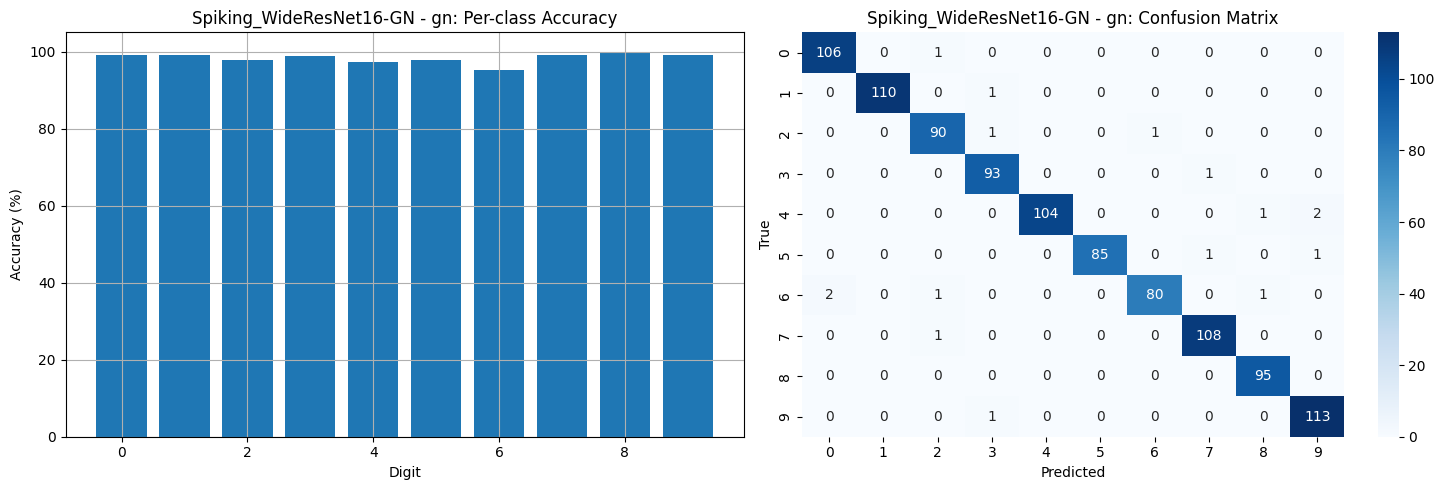

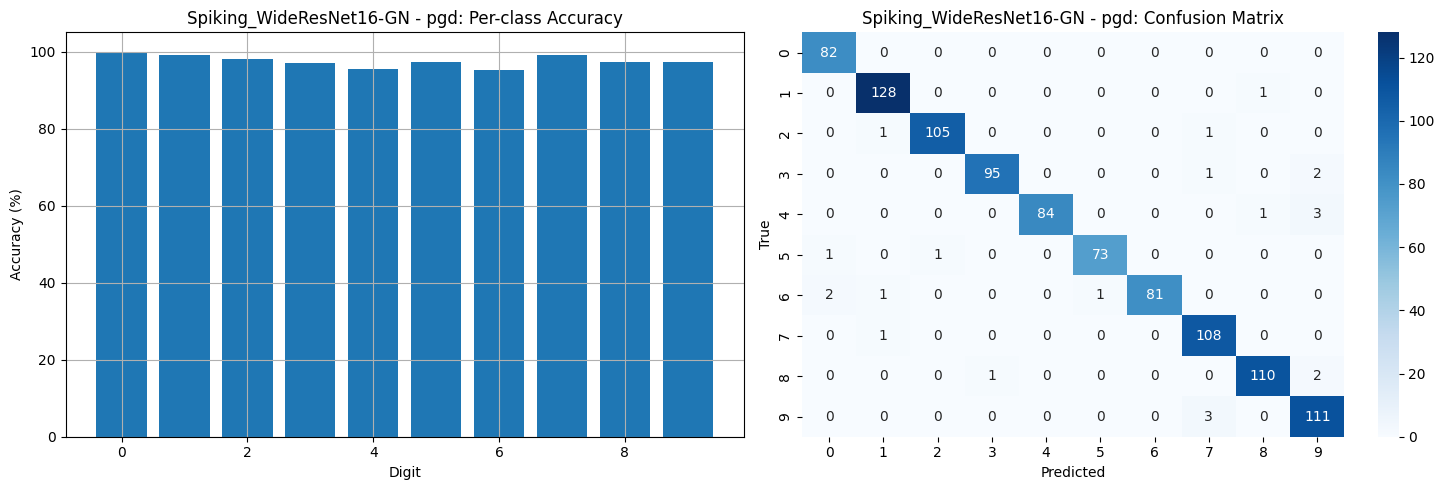

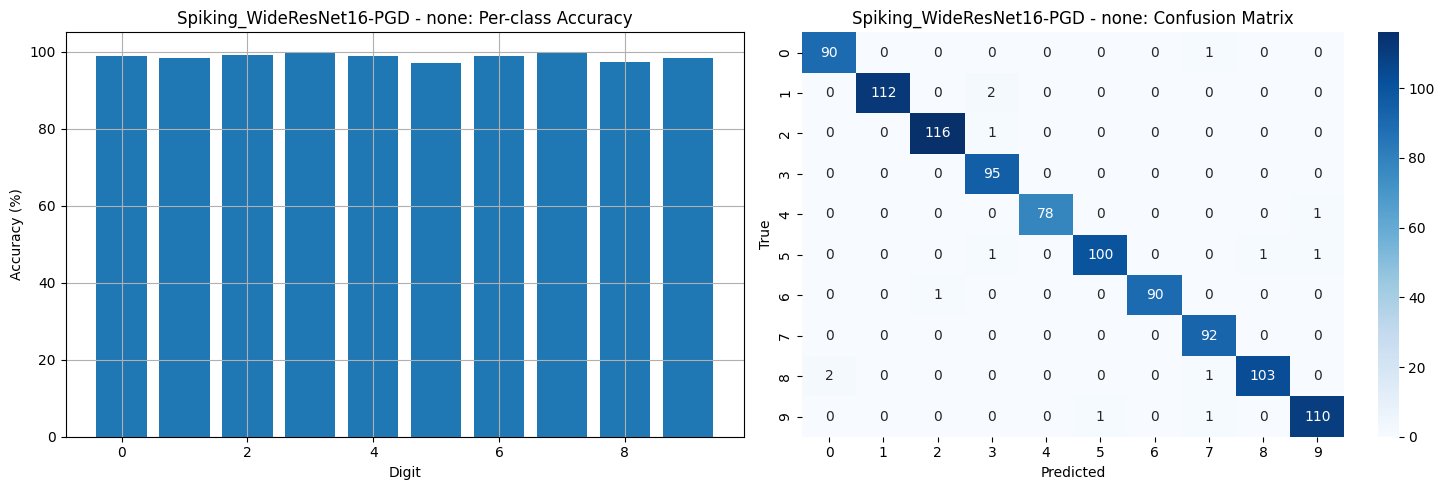

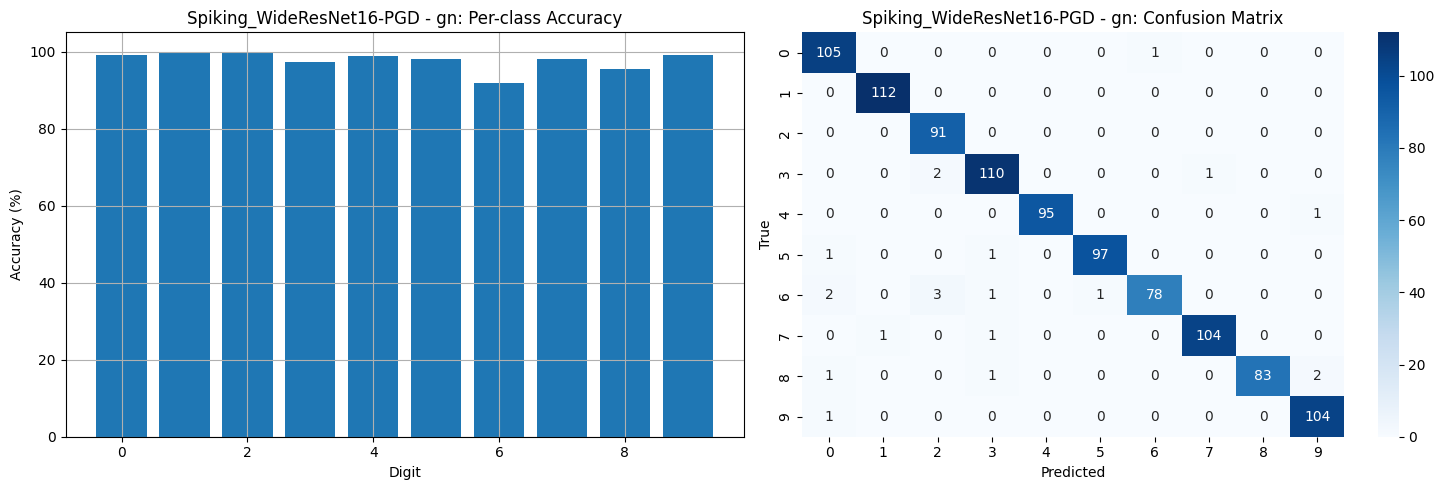

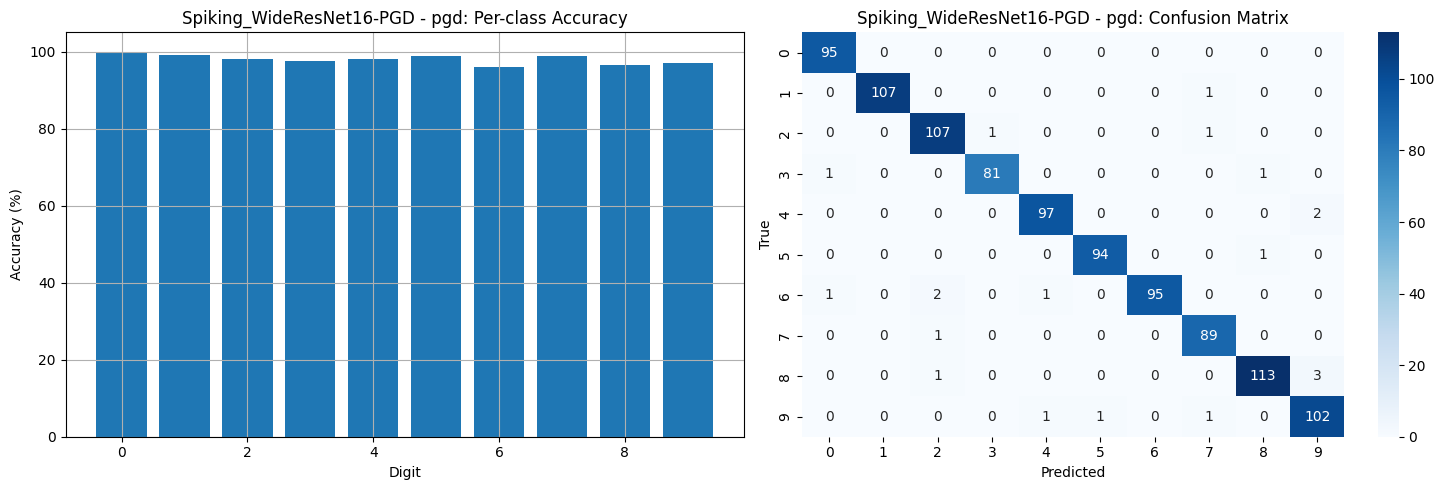

In [12]:
for config in configs:
    model_name = config['name']
    if model_name not in test_results:
        print(f"Warning: Model {model_name} not found in test results")
        continue
        
    for attack_name in ['none', 'gn', 'pgd']:
        if attack_name not in test_results[model_name]:
            print(f"Warning: Attack {attack_name} not found for model {model_name}")
            continue
            
        plt.figure(figsize=(15, 5))
        
        # Per-class accuracy bar plot
        plt.subplot(1, 2, 1)
        class_acc = test_results[model_name][attack_name]['class_accuracies']
        plt.bar(range(10), class_acc)
        plt.xlabel('Digit')
        plt.ylabel('Accuracy (%)')
        plt.title(f'{model_name} - {attack_name}: Per-class Accuracy')
        plt.grid(True)
        
        # Confusion matrix
        plt.subplot(1, 2, 2)
        conf_matrix = test_results[model_name][attack_name]['confusion_matrix']
        # Use '.0f' format for floats that should be displayed as integers
        sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'{model_name} - {attack_name}: Confusion Matrix')
        
        plt.tight_layout()
        plt.show()

In [13]:
# Attack Effectiveness Comparison

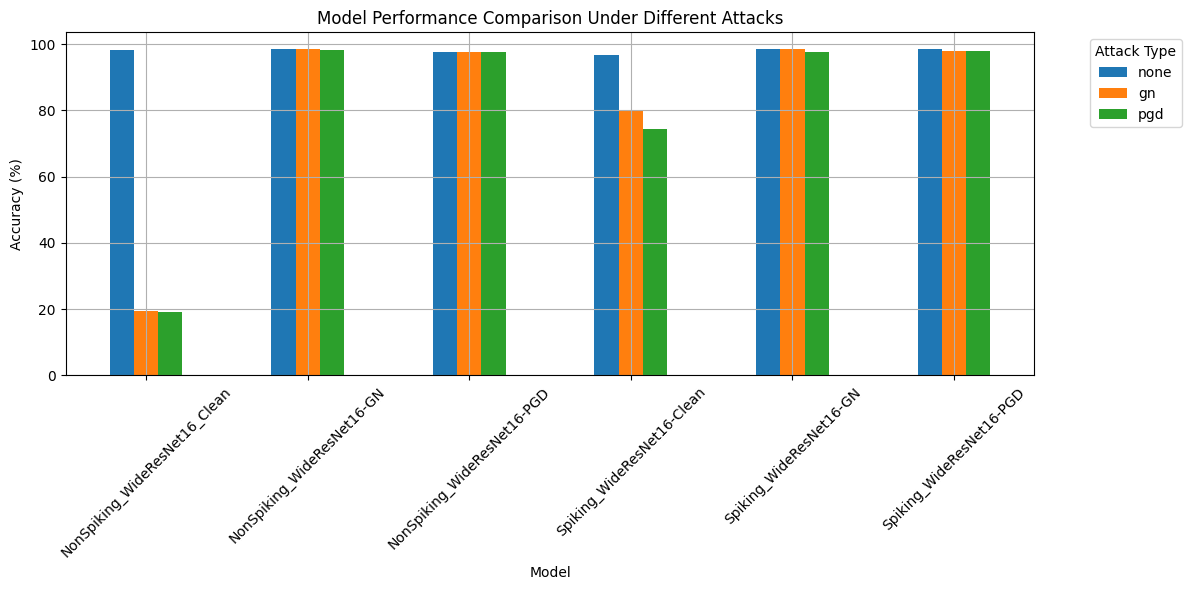

In [14]:
plt.figure(figsize=(12, 6))
x = np.arange(len(model_names))
width = 0.15
multiplier = 0

for attack_name in attack_names:
    attack_accuracies = [test_results[model_name][attack_name]['accuracy'] 
                       for model_name in model_names]
    offset = width * multiplier
    plt.bar(x + offset, attack_accuracies, width, label=attack_name)
    multiplier += 1

plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Model Performance Comparison Under Different Attacks')
plt.xticks(x + width * (len(attack_names)-1)/2, model_names, rotation=45)
plt.legend(title='Attack Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
# Summary Statistics

In [16]:
# Map your preferred display names to the actual keys in test_results
attack_name_mapping = {
    'Clean': 'none',
    'GN (weak)': 'gn',
    'PGD (strong)': 'pgd'
}

print("\nSummary Statistics:")
print("-" * 80)
# Update this header to match your preferred names
print(f"{'Model':<30} {'Clean':>10} {'GN (weak)':>10} {'PGD (strong)':>10}")
print("-" * 80)

for model_name in model_names:
    stats = []
    try:
        # Use the mapping to get the correct keys
        stats = [
            test_results[model_name][attack_name_mapping['Clean']]['accuracy'],
            test_results[model_name][attack_name_mapping['GN (weak)']]['accuracy'],
            test_results[model_name][attack_name_mapping['PGD (strong)']]['accuracy']
        ]
        
        print(f"{model_name:<30}", end="")
        for stat in stats:
            print(f"{stat:>10.2f}", end="")
        print()
    except KeyError as e:
        print(f"{model_name:<30} Error: Missing key {e}")


Summary Statistics:
--------------------------------------------------------------------------------
Model                               Clean  GN (weak) PGD (strong)
--------------------------------------------------------------------------------
NonSpiking_WideResNet16_Clean      98.10     19.50     19.20
NonSpiking_WideResNet16-GN         98.50     98.50     98.30
NonSpiking_WideResNet16-PGD        97.60     97.70     97.60
Spiking_WideResNet16-Clean         96.70     80.00     74.40
Spiking_WideResNet16-GN            98.40     98.40     97.70
Spiking_WideResNet16-PGD           98.60     97.90     98.00
